In [1]:
using Distributions
using StatsBase: ecdf
using StatsFuns: logsumexp
using StatsPlots
default(fmt=:png,
    titlefontsize=10, plot_titlefontsize=10,
    guidefontsize=9, legendfontsize=8, tickfontsize=6)

$$
p(x|a,b)
= (1-a)\frac{e^{-x^2/2}}{\sqrt{2\pi}} + a\frac{e^{-(x-b)^2/2}}{\sqrt{2\pi}}
= \frac{e^{-x^2/2}}{\sqrt{2\pi}}
\left(
1 - a + a e^{bx-b^2/2}
\right)
$$

のとき

$$
\log p(x|a,b) 
= -\frac{x^2}{2} - \log\sqrt{2\pi}
+ \log\left(
1 - a + a e^{bx-b^2/2}
\right)
$$

In [2]:
mixnormal(a, b) = MixtureModel([Normal(), Normal(b, 1)], [1-a, a])

function logpdf_mixnormal(a, b, x)
    -x^2/2 - log(√(2π)) + log1p(-a*(1 - exp(b*x - b^2/2)))
end

function pdf_mixnormal(a, b, x)
    exp(logpdf_mixnormal(a, b, x))
end

function loglik_mixnormal(a, b, X)
    sum(logpdf_mixnormal(a, b, x) for x in X)
end

loglik_mixnormal (generic function with 1 method)

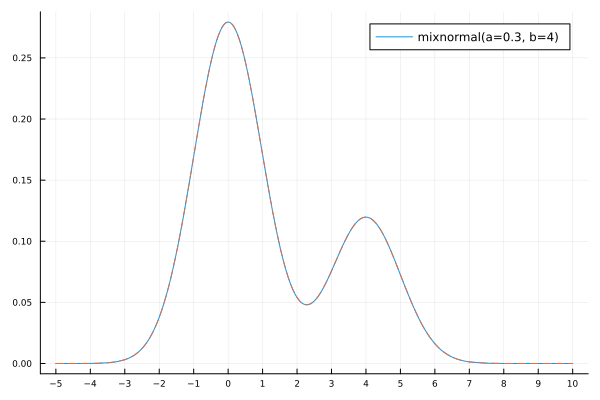

In [3]:
X = randn(10)
a, b = 0.3, 4
plot(x -> pdf_mixnormal(a, b, x), -5, 10; label="mixnormal(a=$a, b=$b)")
plot!(x -> pdf(mixnormal(a, b), x), -5, 10; label="", ls=:dash)
plot!(; xtick=-10:10)

In [4]:
function plot_lik_mixnormal(; a = 0.5, b = 1.0, n = 100)
    PP = Vector{Any}(undef, 20)
    as = range(0, 1, 400)
    bs = range(-4, 4, 400)
    Threads.@threads for i in 1:20
        X = rand(mixnormal(a, b), n)
        logz = loglik_mixnormal.(as, bs', Ref(X))
        maxlogz = maximum(logz)
        w = @. exp(logz - maxlogz)
        P = heatmap(bs, as, w; colorbar=false, tickfontsize=5)
        plot!(xtick=-10:10, ytick=-0:0.1:1)
        PP[i] = P
    end
    plot(PP...; layout=(4, 5), size=(1000, 800))
    plot!(plot_title="true a = $a,  true b = $b,  n = $n")
end

plot_lik_mixnormal (generic function with 1 method)

  2.813931 seconds (4.51 M allocations: 337.999 MiB, 2.46% gc time, 68.83% compilation time: 23% of which was recompilation)


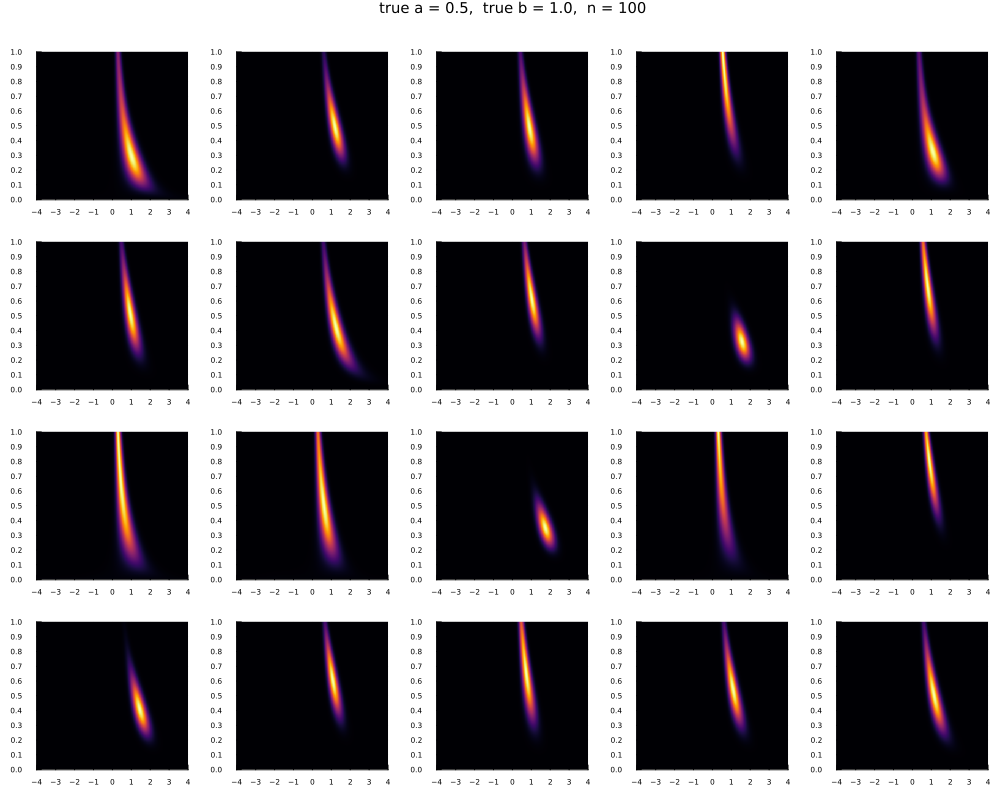

In [5]:
@time plot_lik_mixnormal(; a = 0.5, b = 1.0, n = 100)

  0.901504 seconds (57.27 k allocations: 102.582 MiB)


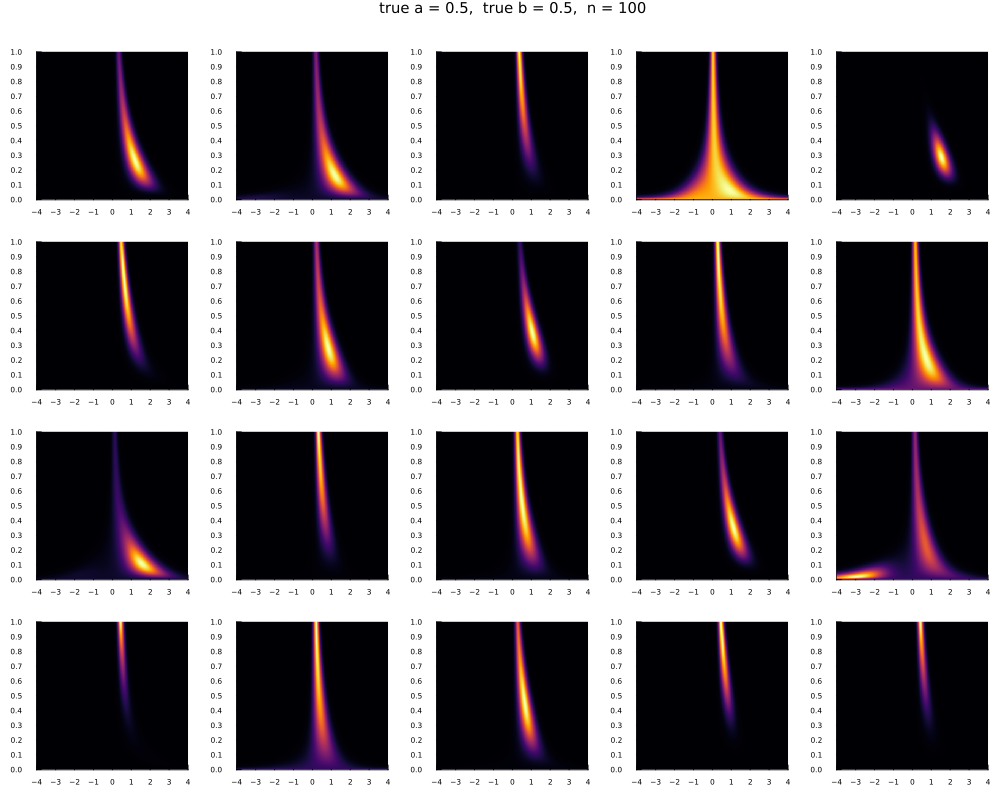

In [6]:
@time plot_lik_mixnormal(; a = 0.5, b = 0.5, n = 100)

  0.917632 seconds (57.29 k allocations: 102.581 MiB)


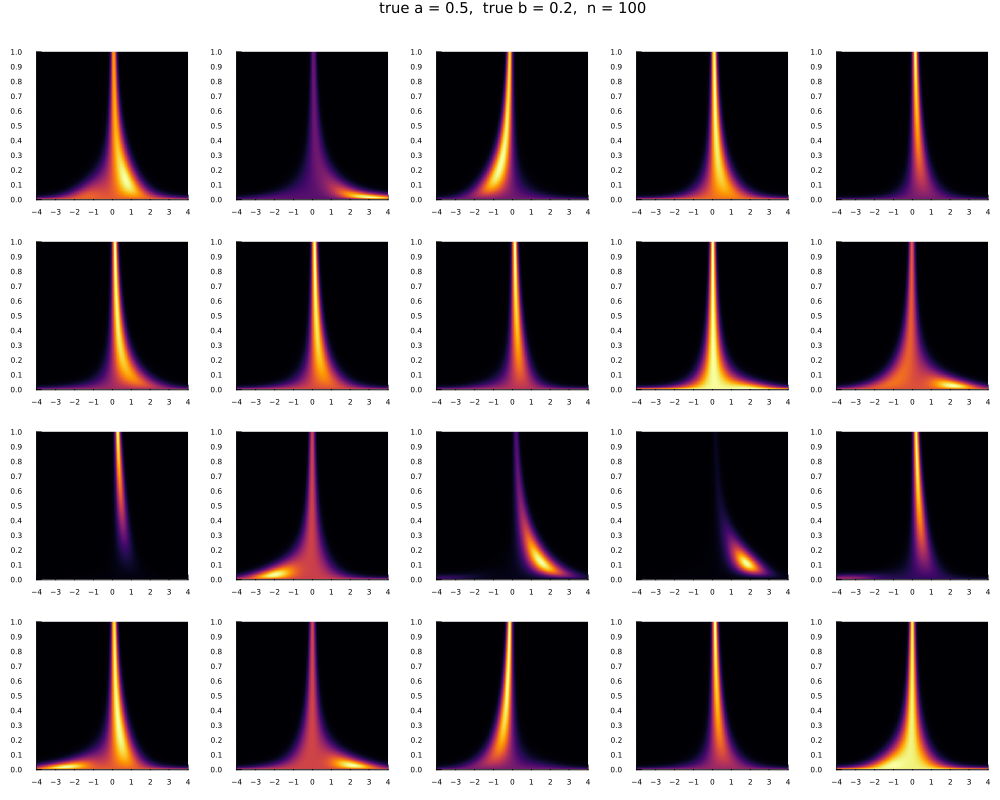

In [7]:
@time plot_lik_mixnormal(; a = 0.5, b = 0.2, n = 100)

  0.912451 seconds (57.29 k allocations: 102.583 MiB)


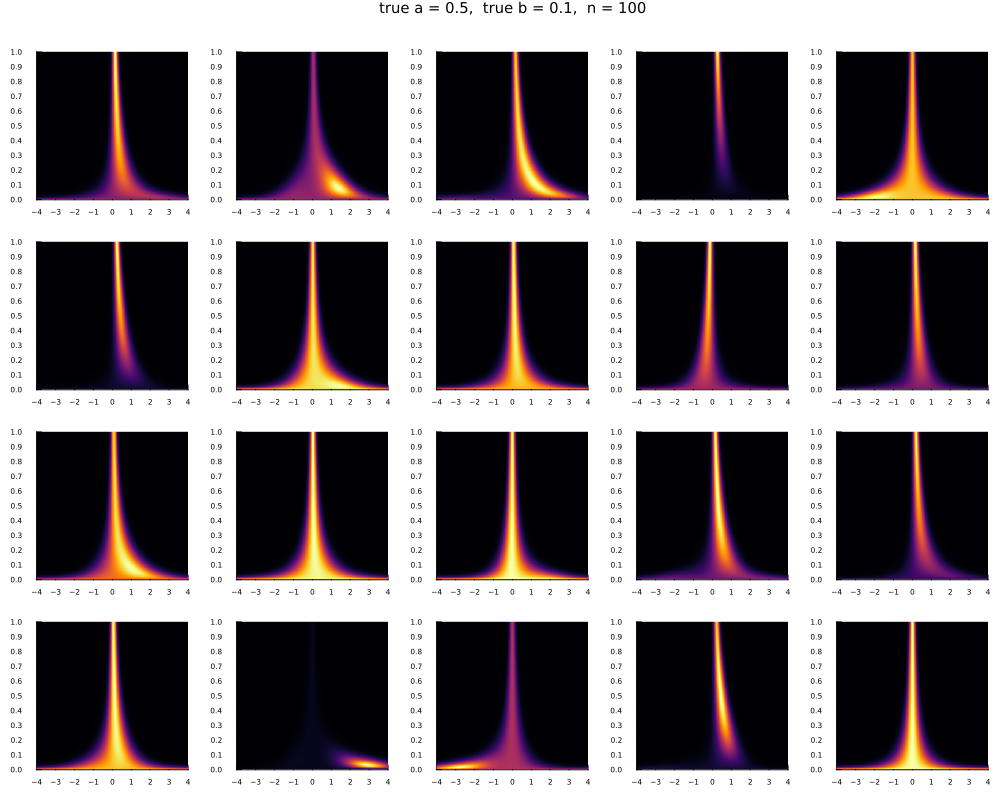

In [8]:
@time plot_lik_mixnormal(; a = 0.5, b = 0.1, n = 100)

  0.914906 seconds (57.29 k allocations: 102.583 MiB)


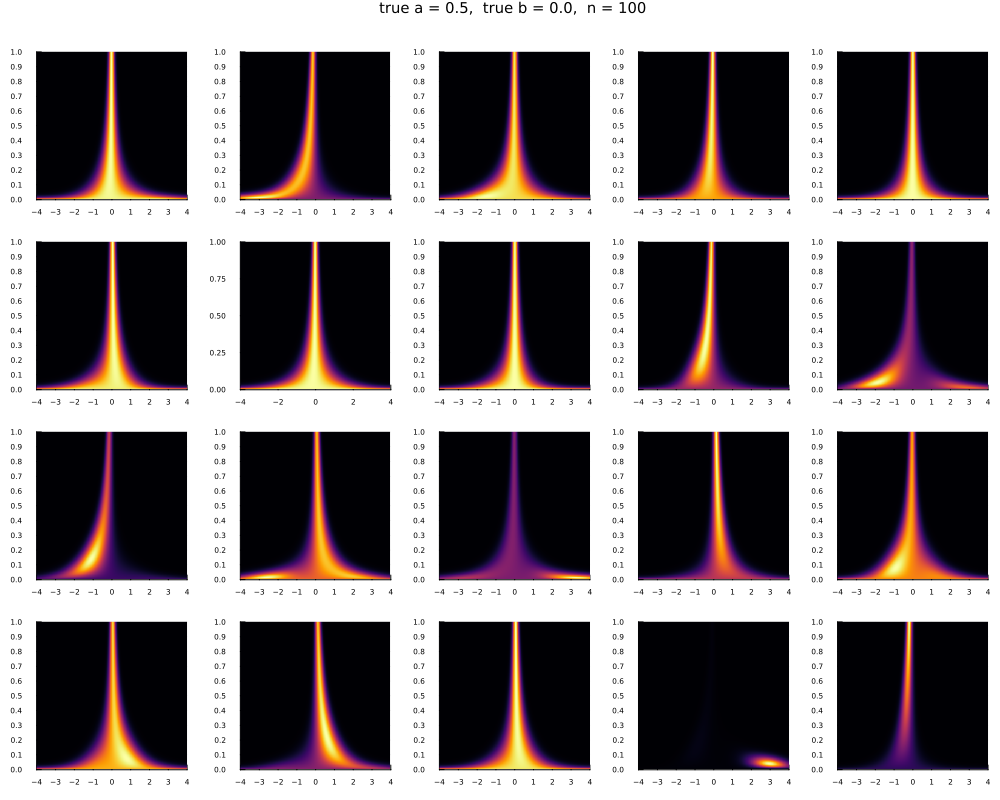

In [9]:
@time plot_lik_mixnormal(; a = 0.5, b = 0.0, n = 100)

In [10]:
regtanh(a, b, x) = Normal(b*tanh(a*x), 1)
loglik_regtanh(a, b, X, Y) = sum(logpdf(regtanh(a, b, x), y) for (x, y) in zip(X, Y))

function plog_lik_regtanh(; a=1, b=1, n=100)
    PP = Vector{Any}(undef, 20)
    X = range(-1, 1, n)
    as = range(-3, 3, 400)
    bs = range(-3, 3, 400)
    Threads.@threads for i in 1:20
        Y = [rand(regtanh(a, b, x)) for x in X]
        logz = loglik_regtanh.(as, bs', Ref(X), Ref(Y))
        maxlogz = maximum(logz)
        w = @. exp(logz - maxlogz)
        P = heatmap(bs, as, w; colorbar=false, tickfontsize=5)
        plot!(xtick=-10:10, ytick=-10:10)
        PP[i] = P
    end
    plot(PP...; layout=(4, 5), size=(1000, 800))
    plot!(plot_title="true a = $a,  true b = $b,  n = $n")
end

plog_lik_regtanh (generic function with 1 method)

  1.328707 seconds (1.26 M allocations: 163.697 MiB, 23.64% compilation time)


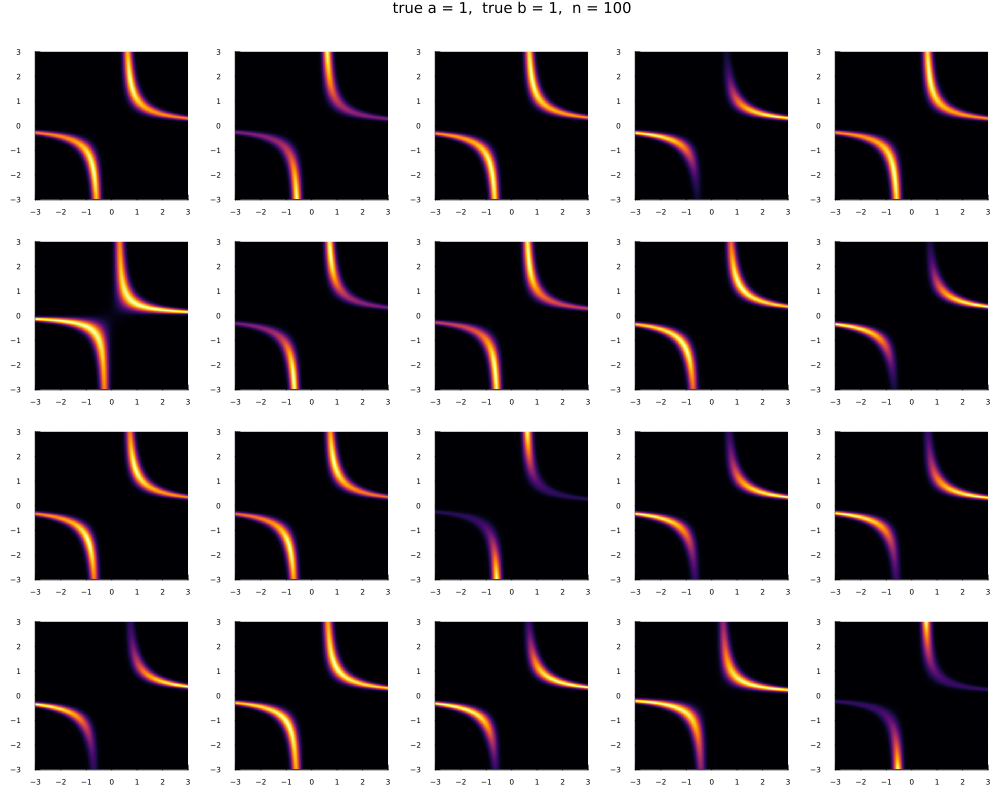

In [11]:
@time plog_lik_regtanh(; a=1, b=1, n=100)

  1.142452 seconds (265.97 k allocations: 112.982 MiB, 8.97% compilation time)


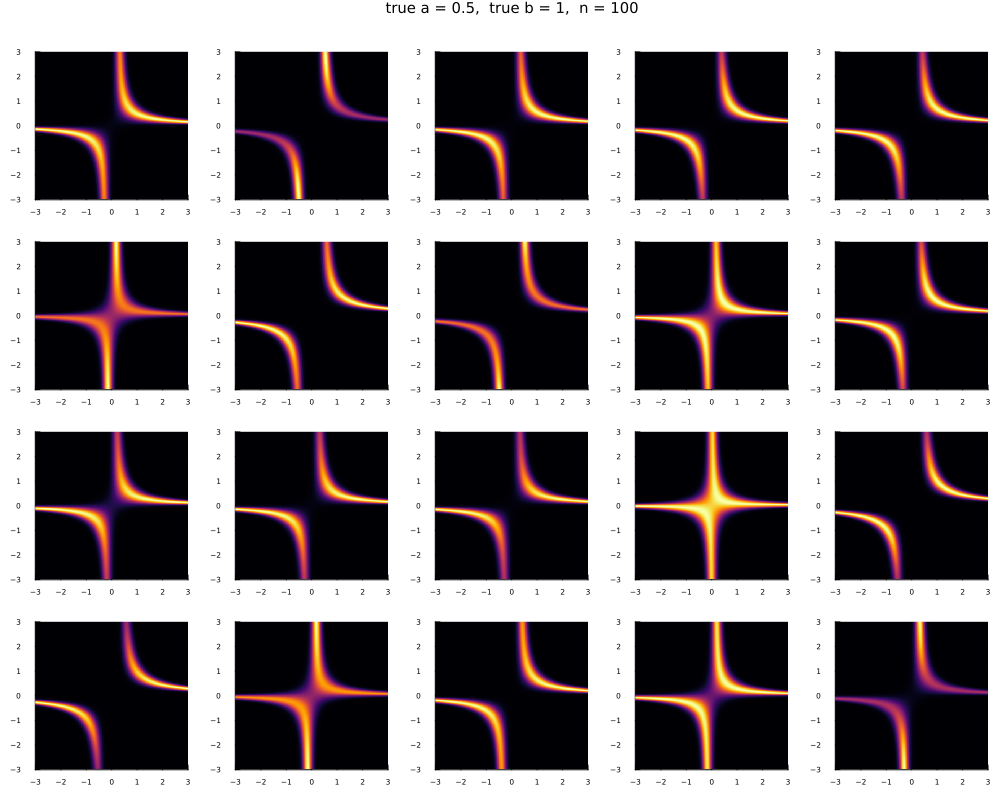

In [12]:
@time plog_lik_regtanh(; a=0.5, b=1, n=100)

  1.045608 seconds (57.15 k allocations: 102.564 MiB)


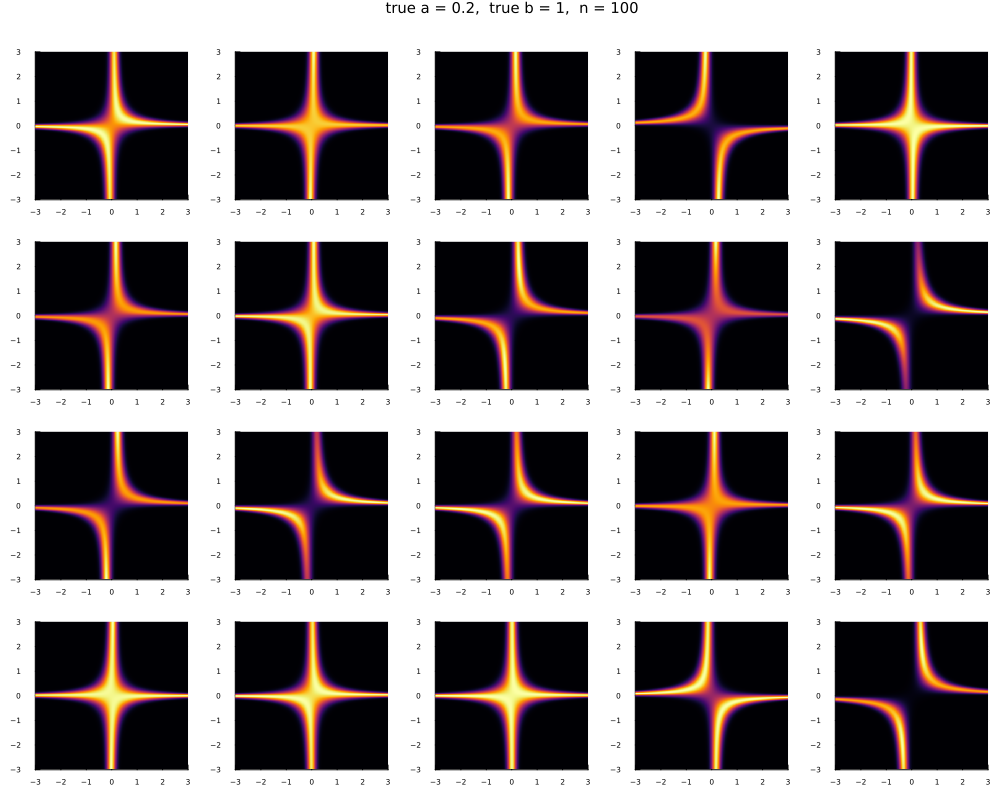

In [13]:
@time plog_lik_regtanh(; a=0.2, b=1, n=100)

  1.034852 seconds (57.15 k allocations: 102.564 MiB)


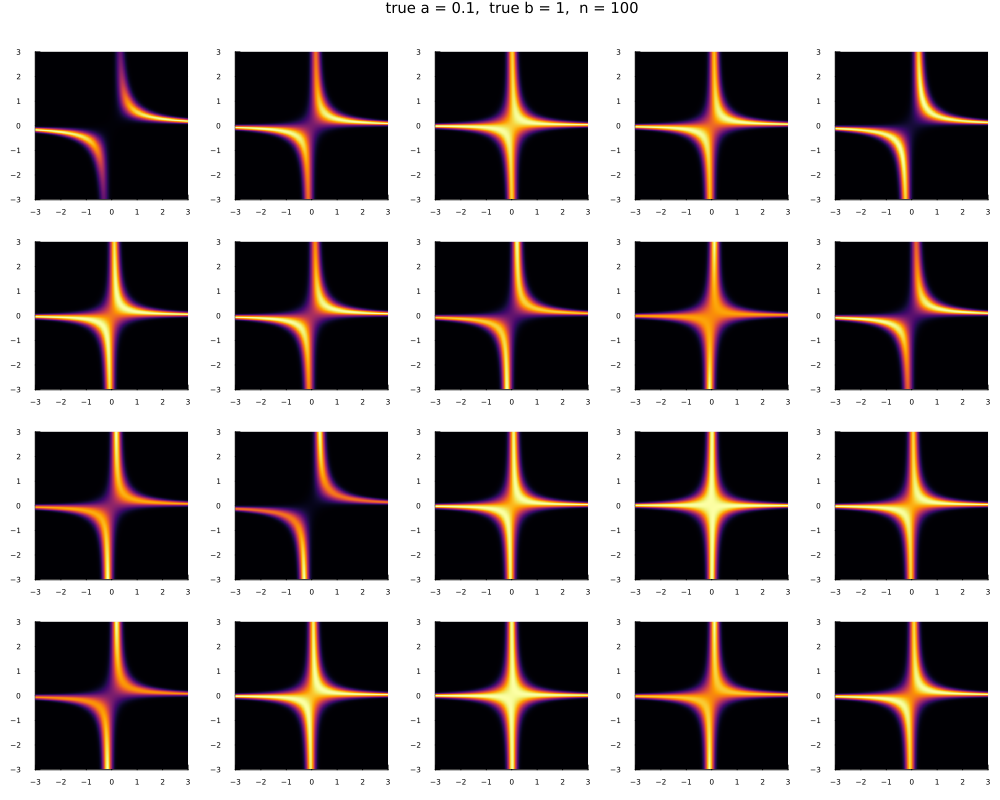

In [14]:
@time plog_lik_regtanh(; a=0.1, b=1, n=100)

  1.037956 seconds (57.15 k allocations: 102.564 MiB)


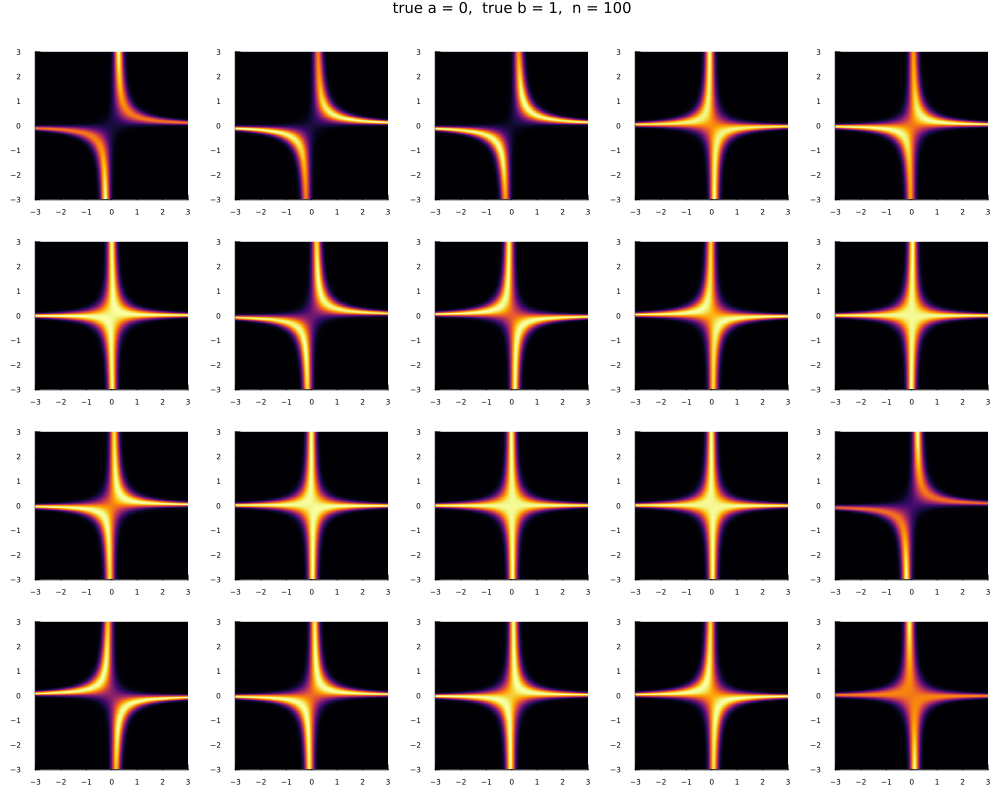

In [15]:
@time plog_lik_regtanh(; a=0, b=1, n=100)

  9.964892 seconds (57.23 k allocations: 102.703 MiB)


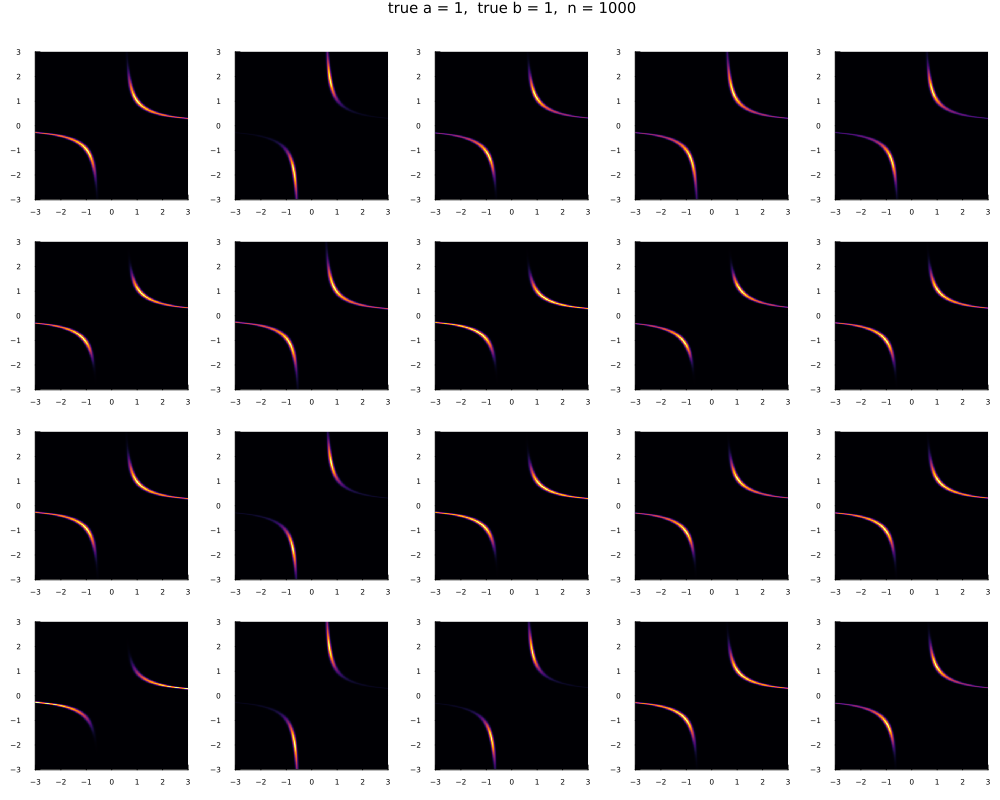

In [16]:
@time plog_lik_regtanh(; a=1, b=1, n=1000)

 10.195588 seconds (57.27 k allocations: 102.705 MiB)


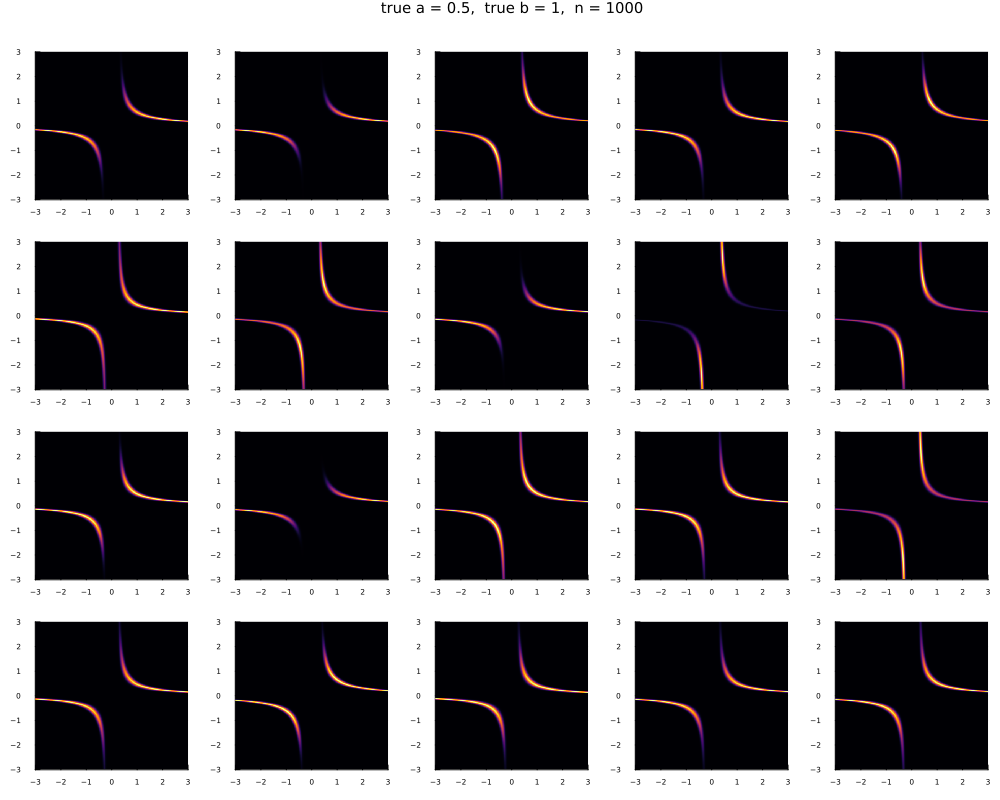

In [17]:
@time plog_lik_regtanh(; a=0.5, b=1, n=1000)

 10.025755 seconds (57.27 k allocations: 102.707 MiB)


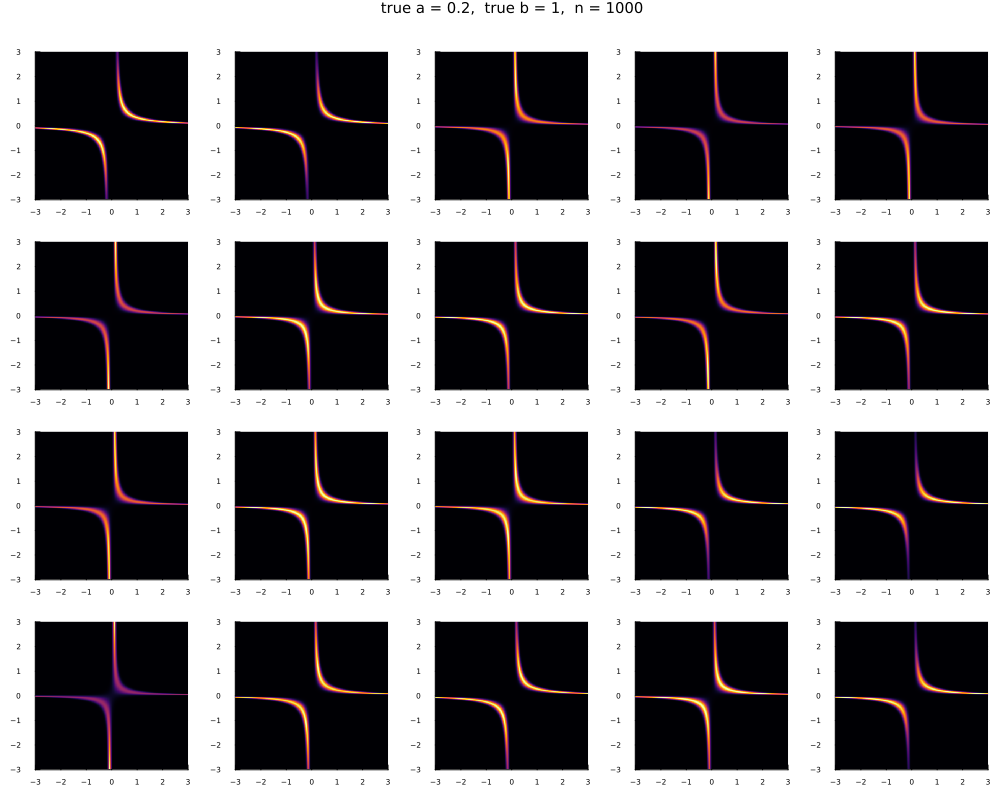

In [18]:
@time plog_lik_regtanh(; a=0.2, b=1, n=1000)

 10.123717 seconds (57.27 k allocations: 102.705 MiB)


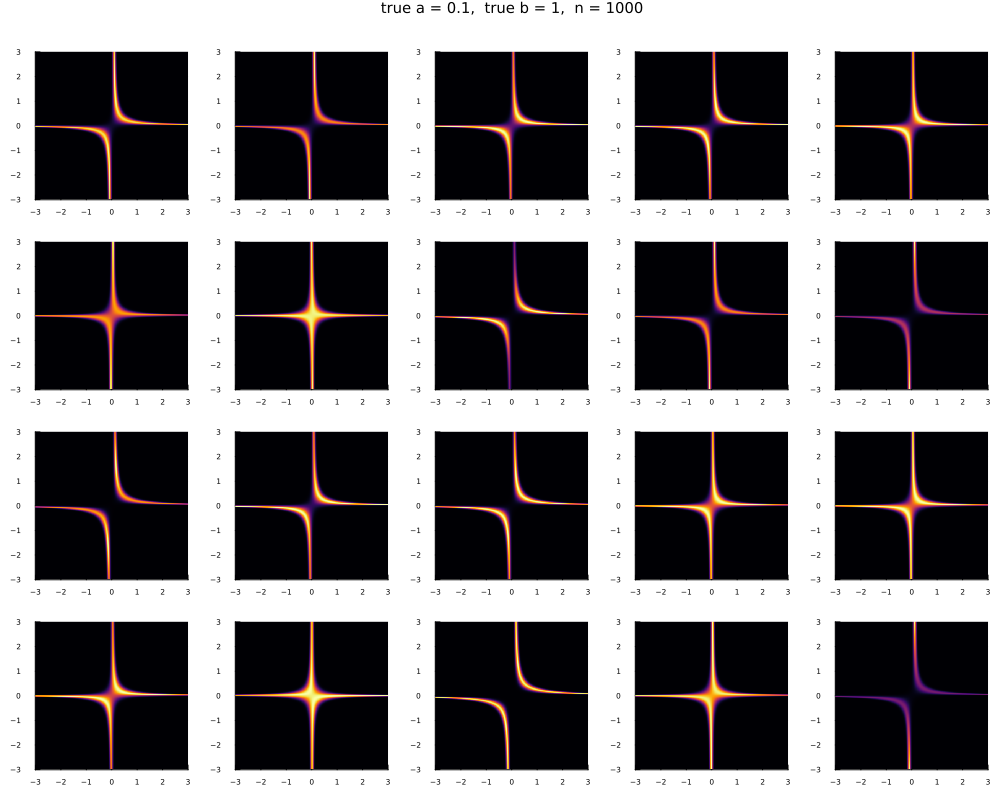

In [19]:
@time plog_lik_regtanh(; a=0.1, b=1, n=1000)

 10.188122 seconds (57.22 k allocations: 102.700 MiB)


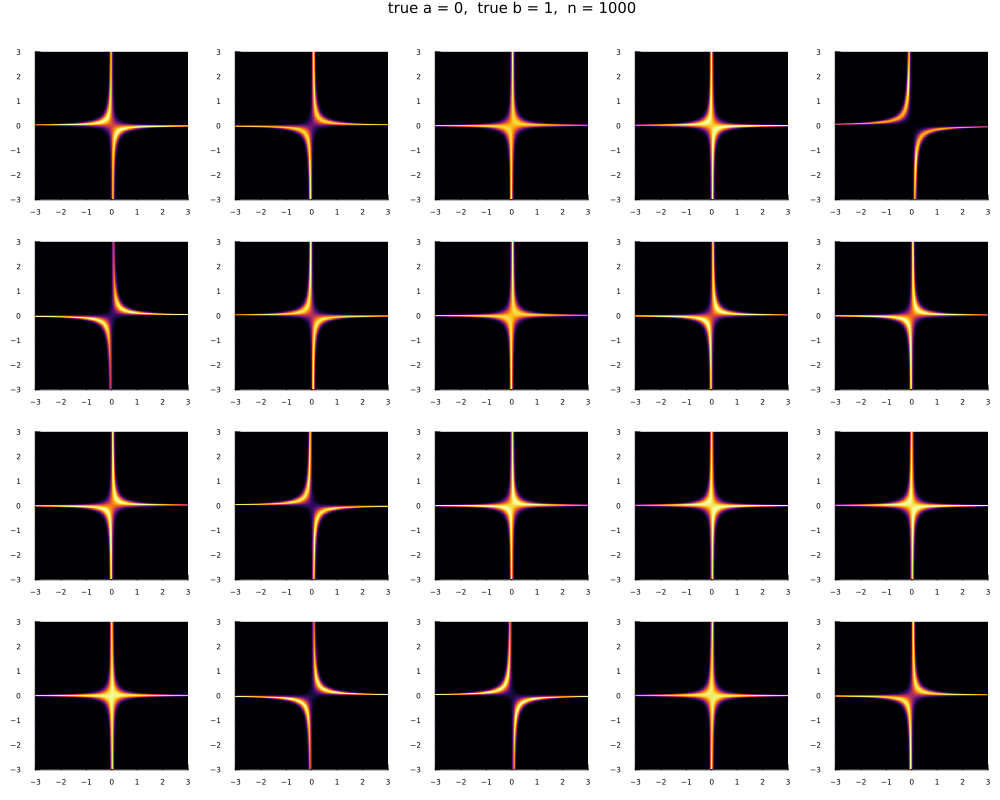

In [20]:
@time plog_lik_regtanh(; a=0, b=1, n=1000)